In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df = pd.read_csv("/content/Loan_default.csv")

In [ ]:
df = df.dropna(subset=['HasCoSigner', 'Default'])
df = df.drop(columns=['LoanID'])

In [ ]:
X = df.drop("Default", axis=1)
y = df["Default"]

In [ ]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

In [ ]:
# Preprocess
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [ ]:
# Model with balancing
xgb = XGBClassifier(
    scale_pos_weight = len(y[y==0]) / len(y[y==1]),
    n_estimators=500,
    learning_rate=0.05,
    eval_metric="logloss"
)

In [ ]:
# Build pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", xgb)
])

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Train model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestR...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Predictions
y_pred = model.predict(X_test)
#y_pred = (model.predict_proba(X_test)[:, 1] >= 0.25).astype(int)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8017161410018553

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.86      0.88      3813
         1.0       0.26      0.37      0.30       499

    accuracy                           0.80      4312
   macro avg       0.58      0.62      0.59      4312
weighted avg       0.84      0.80      0.82      4312



In [ ]:
import joblib
joblib.dump(model, "loan_xgb_pipeline.pkl")


['loan_xgb_pipeline.pkl']

In [ ]:
import shap
shap.initjs()

xgb_model = model.named_steps["classifier"]

In [ ]:
X_train_enc = model.named_steps["preprocess"].transform(X_train)

In [ ]:
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

In [ ]:
feature_names = list(ohe_feature_names) + list(numeric_cols)

In [ ]:
feature_names = list(ohe_feature_names) + list(numeric_cols)

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
shap_values = explainer.shap_values(X_train_enc)

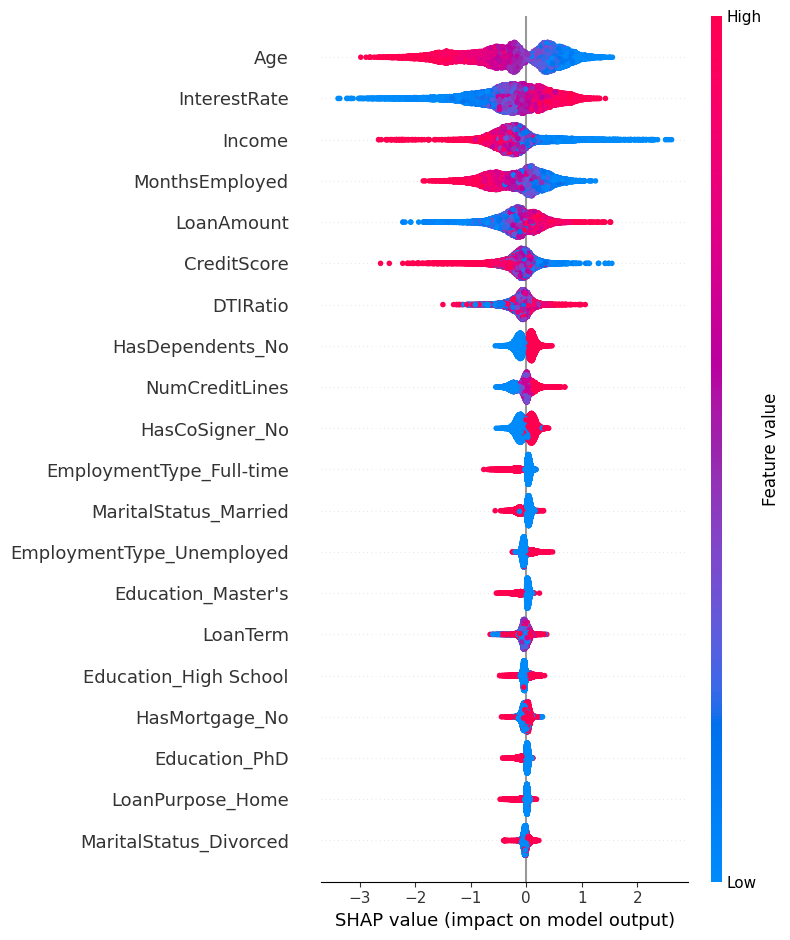

In [ ]:
shap.summary_plot(shap_values, X_train_enc, feature_names=feature_names)

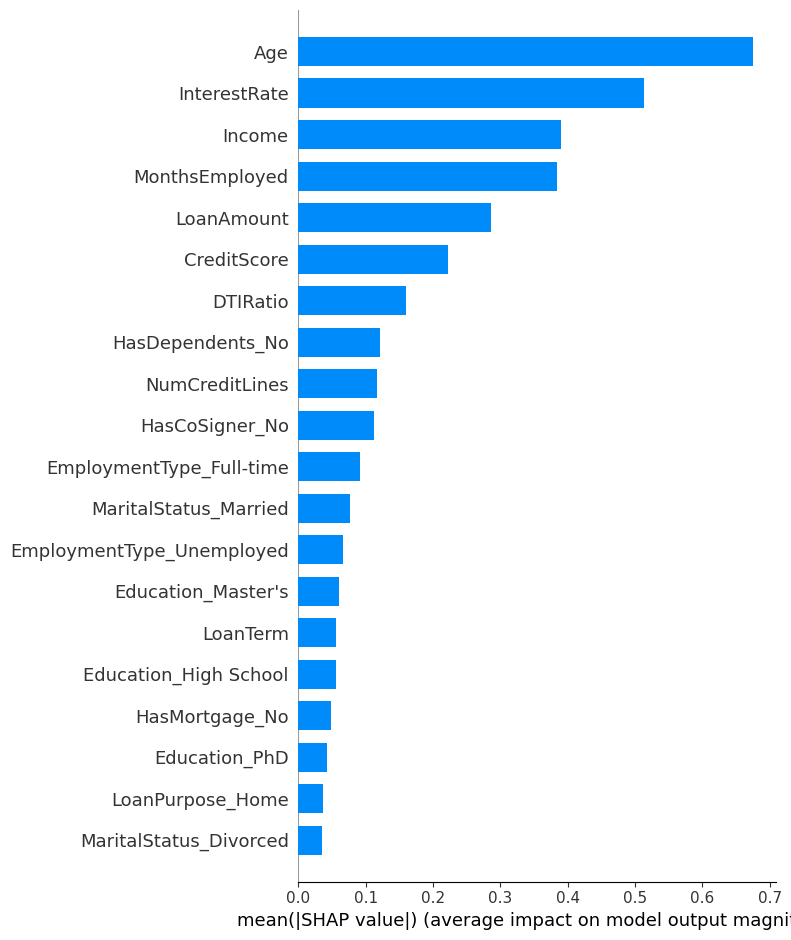

In [ ]:
shap.summary_plot(shap_values, X_train_enc, feature_names=feature_names, plot_type="bar")